# Install and Import Required Libraries


In [ ]:
%pip install tensorflow nibabel dicom2nifti nilearn matplotlib numpy antspyx

In [120]:
import os
import time
import shutil
import subprocess
import dicom2nifti
import ants
import nibabel as nib
import numpy as np
import nilearn.plotting as plotting
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split


# Set the base directory
DATA = "./DATA/ADNI_PP_copy"
METADATA = "./DATA/ADNI_METADATA"

# Utility functions


In [95]:
def get_nii_files(base_dir, prefix=None):
    """Retrieve all NIfTI file paths in the directory, optionally filtering by prefix."""
    found = []

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".nii.gz"):
                file_path = os.path.join(root, file)
                if prefix:
                    if file.startswith(prefix):
                        found.append(file_path)
                else:
                    found.append(file_path)

    return found


def display_nii_stats(base_dir):
    """Display statistics about NIfTI files in the directory"""
    nii_files = get_nii_files(base_dir)
    prefix_counts = {}

    for file in nii_files:
        filename = os.path.basename(file)
        prefix = filename.split("_")[0]
        if prefix in prefix_counts:
            prefix_counts[prefix] += 1
        else:
            prefix_counts[prefix] = 1

    total_files = len(nii_files)

    # Display prefix counts in a pandas grid
    prefix_data = {
        "Prefix": list(prefix_counts.keys()),
        "Count": list(prefix_counts.values()),
    }
    prefix_df = pd.DataFrame(prefix_data)
    prefix_df = prefix_df.sort_values(by="Count", ascending=False)
    prefix_df.loc["Total"] = prefix_df.sum(numeric_only=True)
    print("\nGrid Display for Prefix Counts:")
    display(prefix_df)


def display_comprehensive_stats(base_dir, prefix):
    """Display comprehensive statistics about all NIfTI files starting with the given prefix."""
    display_nii_stats(base_dir)

    print(f"Analysing files with prefix '{prefix}'")
    nii_files = get_nii_files(base_dir, prefix=prefix)

    if not nii_files:
        print(f"No files found with prefix '{prefix}'.")
        return

    total_files = len(nii_files)
    dimensions = []
    voxel_sizes = []
    orientations = []

    for file in nii_files:
        try:
            img = nib.load(file)
            dimensions.append(img.shape)
            voxel_sizes.append(img.header.get_zooms())
            orientations.append(nib.aff2axcodes(img.affine))
        except Exception as e:
            print(f"Error reading {file}: {e}")

    unique_dimensions = {dim: dimensions.count(dim) for dim in set(dimensions)}
    unique_voxel_sizes = {size: voxel_sizes.count(size) for size in set(voxel_sizes)}
    unique_orientations = {
        orient: orientations.count(orient) for orient in set(orientations)
    }

    # Display in grids
    dim_data = {
        "Dimension": list(unique_dimensions.keys()),
        "Frequency": list(unique_dimensions.values()),
    }
    dim_df = pd.DataFrame(dim_data)
    dim_df["Percentage"] = (dim_df["Frequency"] / total_files * 100).round(1)
    dim_df = dim_df.sort_values(by="Frequency", ascending=False)
    print("\nGrid Display for Dimensions:")
    display(dim_df)

    voxel_data = {
        "Voxel Size": list(unique_voxel_sizes.keys()),
        "Frequency": list(unique_voxel_sizes.values()),
    }
    voxel_df = pd.DataFrame(voxel_data)
    voxel_df["Percentage"] = (voxel_df["Frequency"] / total_files * 100).round(1)
    voxel_df = voxel_df.sort_values(by="Frequency", ascending=False)
    print("\nGrid Display for Voxel Sizes:")
    display(voxel_df)

    orient_data = {
        "Orientation": list(unique_orientations.keys()),
        "Frequency": list(unique_orientations.values()),
    }
    orient_df = pd.DataFrame(orient_data)
    orient_df["Percentage"] = (orient_df["Frequency"] / total_files * 100).round(1)
    orient_df = orient_df.sort_values(by="Frequency", ascending=False)
    print("\nGrid Display for Orientations:")
    display(orient_df)

# Convert dicom to NII


In [ ]:
def convert_dicom_to_nifti(base_dir):
    """Converts DICOM files to NIfTI while preserving folder structure."""
    for root, _, files in os.walk(base_dir):
        if any(f.endswith(".dcm") for f in files):
            nii_output_dir = root  # Save in the same directory as DICOMs
            nii_output_path = os.path.join(nii_output_dir, "scan.nii.gz")

            if not os.path.exists(nii_output_path):  # Avoid redundant conversion
                try:
                    dicom2nifti.convert_directory(
                        root, nii_output_dir, compression=True, reorient=True
                    )
                    print(f"Converted: {root} -> {nii_output_path}")

                    # Remove DICOM files after conversion
                    for file in files:
                        os.remove(os.path.join(root, file))
                except Exception as e:
                    print(f"Failed to convert {root}: {e}")


convert_dicom_to_nifti(DATA)

# Skull Stripping


In [ ]:
def run_synthstrip(freesurfer_home, input_path, ss_output_path):
    """Runs SynthStrip on a single NIfTI file."""
    if os.path.exists(ss_output_path):  # Avoid redundant processing
        print(f"Skipping {input_path}, output already exists.")
        return

    try:
        env = os.environ.copy()
        env["FREESURFER_HOME"] = freesurfer_home
        env["SUBJECTS_DIR"] = os.path.join(freesurfer_home, "subjects")

        command = [
            "/bin/bash",
            "-c",  # Use bash explicitly
            f"source {freesurfer_home}/SetUpFreeSurfer.sh && "
            f"mri_synthstrip -i {input_path} -o {ss_output_path}",
        ]

        start_time = time.time()
        subprocess.run(command, check=True, env=env)
        elapsed_time = time.time() - start_time

        print(
            f"✔ Processed: {input_path} -> {ss_output_path} (Time: {elapsed_time:.2f}s)"
        )

    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to process {input_path}: {e}")


def skull_strip_nifti(base_dir, freesurfer_home="/Applications/freesurfer/7.4.1"):
    """Runs SynthStrip on NIfTI files sequentially while preserving folder structure."""
    tasks = []

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".nii.gz") and not file.startswith("ss_"):
                input_path = os.path.join(root, file)
                ss_output_path = os.path.join(root, "ss_" + file)
                tasks.append((freesurfer_home, input_path, ss_output_path))

    total_tasks = len(tasks)
    if total_tasks == 0:
        print("✅ No new NIfTI files to process.")
        return

    print(f"🔍 Found {total_tasks} files to process.")

    start_time = time.time()

    # Process tasks sequentially
    for i, task in enumerate(tasks):
        print(f"[{i+1}/{total_tasks}] Processing: {task[1]}")
        try:
            run_synthstrip(*task)
        except Exception as e:
            print(f"⚠️ Error processing {task[1]}: {e}")

    elapsed_time = time.time() - start_time
    print(f"✅ Finished processing all files in {elapsed_time:.2f}s.")


skull_strip_nifti(DATA)

✅ No new NIfTI files to process.


## Visualise the Stripped Scans


In [ ]:
ss_files = get_nii_files(DATA, "ss_")

# Display the first few NIfTI file paths
print("First few NIfTI files:")
for file in ss_files[:5]:
    print(file)

# Visualize all NIfTI scans
for scan in ss_files[::50]:
    img = nib.load(scan)
    plotting.plot_anat(
        img,
        title=f"Anatomical View: {scan}",
        annotate=False,
        draw_cross=False,
        cut_coords=(0, 0, 0),
    )
    plt.show()

Total number of NIfTI files found: 852
Total number of NIfTI files found with prefix 'ss_': 0
Total number of NIfTI files ignored without prefix 'ss_': 852
Total number of non-NIfTI files found: 13
First few NIfTI files:


# Orientation Standardisation


In [42]:
def check_las_orientation(file_list):
    """
    Checks if each NIfTI file in the provided list is in LAS+ orientation.

    Args:
        file_list (list): List of file paths to .nii.gz files.

    Returns:
        None: Prints the number of LAS+ files and lists any files that are not in LAS+.
    """
    las_count = 0
    non_las_files = []

    for file in file_list:
        try:
            img = nib.load(file)
            original_orientation = nib.aff2axcodes(img.affine)

            if original_orientation == ("L", "A", "S"):
                las_count += 1
            else:
                non_las_files.append((file, original_orientation))

        except Exception as e:
            print(f"Error reading {file}: {e}")

    print(f"\nTotal LAS+ files: {las_count}/{len(file_list)}")

    if non_las_files:
        print("\nFiles not in LAS+ orientation:")
        for file, orientation in non_las_files:
            print(f"{file}: {orientation}")
    else:
        print("All files are already in LAS+ orientation.")


nii_files = get_nii_files(DATA)

check_las_orientation(nii_files)


Total LAS+ files: 852/852
All files are already in LAS+ orientation.


# Intensity Normalization


In [ ]:
def z_score_normalization(image_data):
    """Apply z-score normalization to the image data."""
    mean = np.mean(image_data)
    std = np.std(image_data)
    normalized_data = (image_data - mean) / std
    return normalized_data


def normalize_and_save(file_path, prefix):
    """Normalize the image data and save it to a new file."""
    try:
        img = nib.load(file_path)
        img_data = img.get_fdata()

        normalized_data = z_score_normalization(img_data)
        normalized_img = nib.Nifti1Image(normalized_data, img.affine, img.header)

        normalized_file_path = file_path.replace(prefix, "z_" + prefix)
        nib.save(normalized_img, normalized_file_path)
        print(f"Normalized and saved: {normalized_file_path}")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")


def normalize_all_skull_stripped_files(base_dir):
    """Normalize all skull-stripped NIfTI files in the directory."""
    ss_files = get_nii_files(base_dir, prefix="ss_")
    for file_path in ss_files:
        normalize_and_save(file_path, "ss_")


normalize_all_skull_stripped_files(DATA)

# Spatial Normalisation


## Reasons I do NOT Need Spatial Normalization

1. ADNI-1 T1W data is already preprocessed
   - ADNI follows a standardized acquisition protocol, ensuring consistent voxel sizes and orientations across patients.
   - If you’re only using ADNI-1 (no ADNI-2 or ADNI-3), there’s less variation in scanner settings, meaning alignment might already be sufficient.
2. CNNs Learn Spatial Features
   - If you're using a deep learning model (e.g., CNN), it can learn spatial variations on its own.
   - Adding spatial normalization could remove subtle differences in brain shape that might be relevant for classification.
3. Preserving Native Brain Shape
   - Some models benefit from analyzing brain atrophy without forced alignment to MNI space.
   - If you want to measure structural differences in their original form (e.g., hippocampal shrinkage), keeping scans in native space may be better.


# Bias Field Correction


Total number of NIfTI files found: 1553
Total number of NIfTI files found with prefix 'z_ss_': 851
Total number of NIfTI files ignored without prefix 'z_ss_': 702
Total number of non-NIfTI files found: 13
Skipping ./DATA/ADNI_Z_SS_copy/062_S_0690/MPRAGE/2007-01-29_16_15_42.0/I37639/z_ss_4_mprage.nii.gz, bias-corrected file already exists.
Skipping ./DATA/ADNI_Z_SS_copy/062_S_0690/MPRAGE/2006-07-18_10_19_47.0/I19123/z_ss_3_mprage.nii.gz, bias-corrected file already exists.
Skipping ./DATA/ADNI_Z_SS_copy/062_S_0690/MPRAGE/2007-07-31_09_21_42.0/I63347/z_ss_3_mprage.nii.gz, bias-corrected file already exists.
Skipping ./DATA/ADNI_Z_SS_copy/062_S_0690/MPRAGE/2008-07-29_10_46_39.0/I114599/z_ss_3_mprage.nii.gz, bias-corrected file already exists.
Skipping ./DATA/ADNI_Z_SS_copy/013_S_0699/MPRAGE/2006-08-28_15_00_26.0/I23534/z_ss_2_mprage.nii.gz, bias-corrected file already exists.
Skipping ./DATA/ADNI_Z_SS_copy/067_S_0828/MPRAGE/2006-09-05_09_39_23.0/I23809/z_ss_2_mprage.nii.gz, bias-corrected

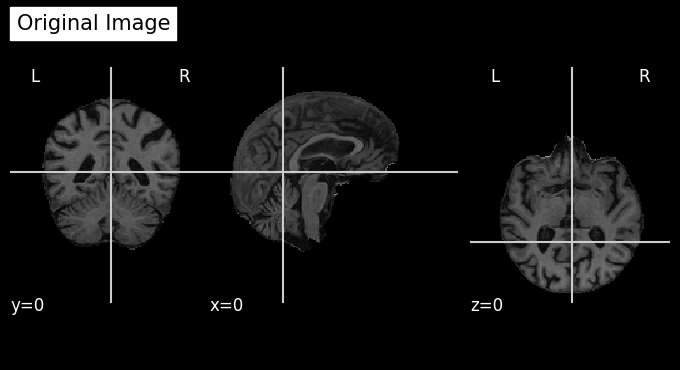

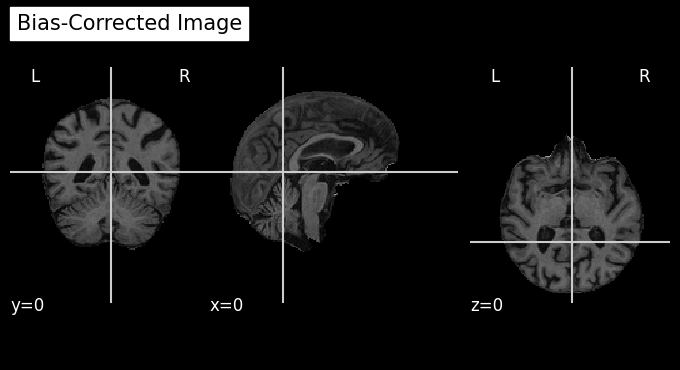

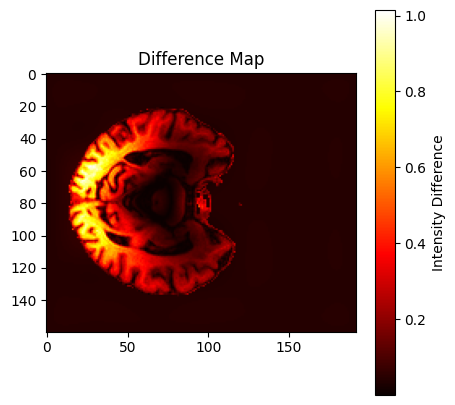

In [ ]:
# Get all z-score normalized skull-stripped files
nii_files = get_nii_files(DATA, "z_ss_")

# Apply N4 Bias Field Correction to all files
for file in nii_files:
    bias_corrected_path = file.replace("z_ss_", "bc_z_ss_")

    if not os.path.exists(bias_corrected_path):
        # Load the skull-stripped image
        input_image = ants.image_read(file)

        # Apply N4 Bias Field Correction
        bias_corrected = ants.n4_bias_field_correction(input_image)

        # Save the bias-corrected image
        ants.image_write(bias_corrected, bias_corrected_path)
        print(f"Bias-corrected image saved to: {bias_corrected_path}")
    else:
        print(f"Skipping {file}, bias-corrected file already exists.")

# Load one bias-corrected image for comparison
if len(nii_files) >= 1:
    original_image = nib.load(nii_files[0])
    bias_corrected_image = nib.load(nii_files[0].replace("z_ss_", "bc_z_ss_"))

    # Plot the middle slice of the original scan
    plotting.plot_anat(original_image, title="Original Image", cut_coords=(0, 0, 0))
    plt.show()

    # Plot the middle slice of the bias-corrected scan
    plotting.plot_anat(
        bias_corrected_image, title="Bias-Corrected Image", cut_coords=(0, 0, 0)
    )
    plt.show()

    # Convert to numpy arrays
    original_data = original_image.get_fdata()
    bias_corrected_data = bias_corrected_image.get_fdata()

    # Choose a slice index
    slice_idx = original_data.shape[2] // 2  # Middle slice

    # Compute absolute difference
    difference = np.abs(
        original_data[:, :, slice_idx] - bias_corrected_data[:, :, slice_idx]
    )

    # Plot difference heatmap
    plt.figure(figsize=(5, 5))
    plt.imshow(difference, cmap="hot")
    plt.colorbar(label="Intensity Difference")
    plt.title("Difference Map")
    plt.show()
else:
    print("Not enough files for comparison.")

# Voxel Standardisation


## Check for uniform voxality


In [47]:
def check_uniform_voxel_size(file_list):
    """
    Checks if all NIfTI files in the provided list have uniform voxel size.

    Args:
        file_list (list): List of file paths to .nii.gz files.

    Returns:
        None: Prints the result of the check.
    """
    voxel_size_counts = {}

    for file in file_list:
        try:
            img = nib.load(file)
            voxel_size = img.header.get_zooms()
            if voxel_size in voxel_size_counts:
                voxel_size_counts[voxel_size] += 1
            else:
                voxel_size_counts[voxel_size] = 1
        except Exception as e:
            print(f"Error reading {file}: {e}")

    if len(voxel_size_counts) == 1:
        print("All files have uniform voxel size:", list(voxel_size_counts.keys())[0])
    else:
        print("Files have different voxel sizes:")
        for voxel_size, count in voxel_size_counts.items():
            print(f"Voxel size: {voxel_size}, Count: {count}")


# Check voxel size for all NIfTI files
nii_files = get_nii_files(DATA, prefix="bc_")
check_uniform_voxel_size(nii_files)

Files have different voxel sizes:
Voxel size: (np.float32(1.2), np.float32(1.3020834), np.float32(1.3020834)), Count: 34
Voxel size: (np.float32(1.2), np.float32(1.25), np.float32(1.25)), Count: 584
Voxel size: (np.float32(1.2), np.float32(1.0), np.float32(1.0)), Count: 214
Voxel size: (np.float32(1.1999999), np.float32(1.25), np.float32(1.25)), Count: 1
Voxel size: (np.float32(1.2000046), np.float32(1.0), np.float32(1.0)), Count: 8
Voxel size: (np.float32(1.2), np.float32(1.2760416), np.float32(1.2760416)), Count: 1
Voxel size: (np.float32(1.2), np.float32(1.3541666), np.float32(1.3541666)), Count: 2
Voxel size: (np.float32(1.2), np.float32(1.046875), np.float32(1.046875)), Count: 2
Voxel size: (np.float32(1.1999999), np.float32(1.3020834), np.float32(1.3020834)), Count: 1
Voxel size: (np.float32(1.199997), np.float32(1.0), np.float32(1.0)), Count: 3
Voxel size: (np.float32(1.2), np.float32(1.1979166), np.float32(1.1979166)), Count: 1


## Resample Voxel Size


Resampled and saved: ./DATA/ADNI_Z_SS_copy/062_S_0690/MPRAGE/2007-01-29_16_15_42.0/I37639/resampled_bc_z_ss_4_mprage.nii.gz
Original resolution: (np.float32(1.2), np.float32(1.3020834), np.float32(1.3020834))
Resampled resolution: (np.float32(1.0), np.float32(1.0), np.float32(1.0))


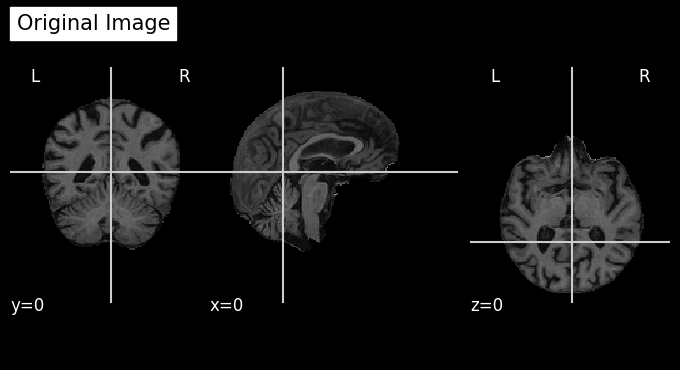

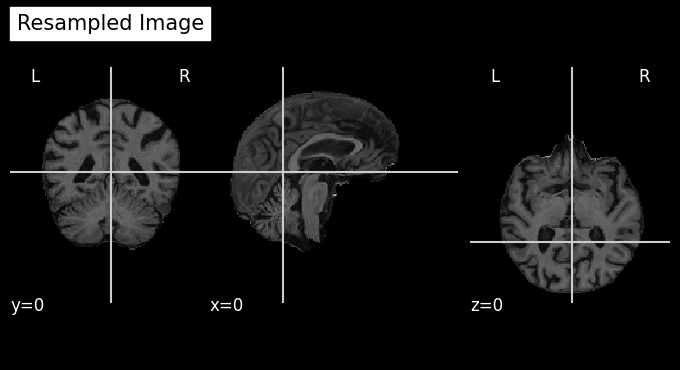

In [ ]:
def resample(file_path, output_path, target=(1, 1, 1)):
    """Resample a NIfTI file to 1x1x1 mm voxel size using ANTs."""
    try:
        # Load the image
        img = ants.image_read(file_path)

        # Resample the image to 1x1x1 mm voxel size
        resampled_img = ants.resample_image(img, target, use_voxels=False)

        # Save the resampled image
        ants.image_write(resampled_img, output_path)
        print(f"Resampled and saved: {output_path}")

    except Exception as e:
        print(f"Error resampling {file_path}: {e}")


def test_resample_single_image(file_path):
    """Test resampling on a single image and display the outputs."""
    resampled_file_path = file_path.replace("bc_", "resampled_bc_")
    resample(file_path, resampled_file_path)

    # Load the original and resampled images
    original_img = nib.load(file_path)
    resampled_img = nib.load(resampled_file_path)

    # Display the resolutions
    original_resolution = original_img.header.get_zooms()
    resampled_resolution = resampled_img.header.get_zooms()
    print(f"Original resolution: {original_resolution}")
    print(f"Resampled resolution: {resampled_resolution}")

    # Plot the middle slice of the original scan
    plotting.plot_anat(original_img, title="Original Image", cut_coords=(0, 0, 0))
    plt.show()

    # Plot the middle slice of the resampled scan
    plotting.plot_anat(resampled_img, title="Resampled Image", cut_coords=(0, 0, 0))
    plt.show()


# Test the resampling on a single image
test_resample_single_image(nii_files[0])

In [ ]:
def resample_all_bc_files(base_dir):
    """Resample all bias-corrected NIfTI files in the directory to 1x1x1 mm voxel size."""
    bc_files = get_nii_files(base_dir, prefix="bc_")
    for file_path in bc_files:
        resampled_file_path = file_path.replace("bc_", "resampled_bc_")
        if not os.path.exists(resampled_file_path):
            resample(file_path, resampled_file_path)
        else:
            print(f"Skipping {file_path}, resampled file already exists.")


resample_all_bc_files(DATA)

Total number of NIfTI files found: 1703
Total number of NIfTI files found with prefix 'bc_': 851
Total number of NIfTI files ignored without prefix 'bc_': 852
Total number of non-NIfTI files found: 13
Skipping ./DATA/ADNI_Z_SS_copy/062_S_0690/MPRAGE/2007-01-29_16_15_42.0/I37639/bc_z_ss_4_mprage.nii.gz, resampled file already exists.
Resampled and saved: ./DATA/ADNI_Z_SS_copy/062_S_0690/MPRAGE/2006-07-18_10_19_47.0/I19123/resampled_bc_z_ss_3_mprage.nii.gz
Resampled and saved: ./DATA/ADNI_Z_SS_copy/062_S_0690/MPRAGE/2007-07-31_09_21_42.0/I63347/resampled_bc_z_ss_3_mprage.nii.gz
Resampled and saved: ./DATA/ADNI_Z_SS_copy/062_S_0690/MPRAGE/2008-07-29_10_46_39.0/I114599/resampled_bc_z_ss_3_mprage.nii.gz
Resampled and saved: ./DATA/ADNI_Z_SS_copy/013_S_0699/MPRAGE/2006-08-28_15_00_26.0/I23534/resampled_bc_z_ss_2_mprage.nii.gz
Resampled and saved: ./DATA/ADNI_Z_SS_copy/067_S_0828/MPRAGE/2006-09-05_09_39_23.0/I23809/resampled_bc_z_ss_2_mprage.nii.gz
Resampled and saved: ./DATA/ADNI_Z_SS_copy/0

# Dimension Standardisation


In [105]:
display_comprehensive_stats(DATA, "resampled_")


Grid Display for Prefix Counts:


,Prefix,Count
0,reshaped,851.0
Total,NaN,851.0


Analysing files with prefix 'resampled_'
No files found with prefix 'resampled_'.


In [100]:
def pad_or_crop(image_data, target_shape=(192, 240, 240)):
    """
    Pad or crop the image data to match the target shape.

    Args:
        image_data (numpy.ndarray): The input image data.
        target_shape (tuple): The target shape (depth, height, width).

    Returns:
        numpy.ndarray: The reshaped image data.
    """
    current_shape = image_data.shape
    pad_width = [(0, 0)] * len(current_shape)
    crop_slices = [slice(None)] * len(current_shape)

    for i in range(len(current_shape)):
        if current_shape[i] < target_shape[i]:  # Need Padding
            pad_size = target_shape[i] - current_shape[i]
            pad_width[i] = (pad_size // 2, pad_size - pad_size // 2)
        elif current_shape[i] > target_shape[i]:  # Need Cropping
            crop_start = (current_shape[i] - target_shape[i]) // 2
            crop_slices[i] = slice(crop_start, crop_start + target_shape[i])

    # Apply cropping
    image_data = image_data[tuple(crop_slices)]

    # Apply padding (safe even if pad_width is all (0,0))
    image_data = np.pad(image_data, pad_width, mode="constant", constant_values=0)

    return image_data


def reshape_all_files(file_list, prefix="resampled_"):
    """
    Reshape all NIfTI files in the list to the target shape.

    Args:
        file_list (list): List of file paths to .nii.gz files.
        target_shape (tuple): The target shape (height, width, depth).

    Returns:
        None: Saves the reshaped files.
    """
    for file_path in file_list:
        reshaped_file_path = file_path.replace(prefix, "reshaped_" + prefix)
        if os.path.exists(reshaped_file_path):
            print(f"Skipping {file_path}, reshaped file already exists.")
            continue

        try:
            img = nib.load(file_path)
            img_data = img.get_fdata()

            reshaped_data = pad_or_crop(img_data)
            reshaped_img = nib.Nifti1Image(reshaped_data, img.affine, img.header)

            nib.save(reshaped_img, reshaped_file_path)
            print(f"Reshaped and saved: {reshaped_file_path}")

        except Exception as e:
            print(f"Error processing {file_path}: {e}")


# Reshape all bias-corrected files
prefix = "resampled_"
nii_files = get_nii_files(DATA, prefix=prefix)
reshape_all_files(nii_files, prefix=prefix)

Skipping ./DATA/ADNI_Z_SS_copy/062_S_0690/MPRAGE/2007-01-29_16_15_42.0/I37639/resampled_bc_z_ss_4_mprage.nii.gz, reshaped file already exists.
Skipping ./DATA/ADNI_Z_SS_copy/062_S_0690/MPRAGE/2006-07-18_10_19_47.0/I19123/resampled_bc_z_ss_3_mprage.nii.gz, reshaped file already exists.
Skipping ./DATA/ADNI_Z_SS_copy/062_S_0690/MPRAGE/2007-07-31_09_21_42.0/I63347/resampled_bc_z_ss_3_mprage.nii.gz, reshaped file already exists.
Skipping ./DATA/ADNI_Z_SS_copy/062_S_0690/MPRAGE/2008-07-29_10_46_39.0/I114599/resampled_bc_z_ss_3_mprage.nii.gz, reshaped file already exists.
Skipping ./DATA/ADNI_Z_SS_copy/013_S_0699/MPRAGE/2006-08-28_15_00_26.0/I23534/resampled_bc_z_ss_2_mprage.nii.gz, reshaped file already exists.
Skipping ./DATA/ADNI_Z_SS_copy/067_S_0828/MPRAGE/2006-09-05_09_39_23.0/I23809/resampled_bc_z_ss_2_mprage.nii.gz, reshaped file already exists.
Skipping ./DATA/ADNI_Z_SS_copy/067_S_0828/MPRAGE/2006-11-09_11_27_58.0/I29294/resampled_bc_z_ss_2_mprage.nii.gz, reshaped file already exists

### **Justification for Selecting (192, 240, 240) as the Target Image Resolution**

Neuroimaging studies that utilize **T1-weighted MRI scans** for Alzheimer's disease classification must ensure that all images conform to a standardized spatial resolution and voxel size. This standardization is crucial for:

1. **Reducing inter-subject variability**, ensuring that machine learning models generalize well.
2. **Mitigating artifacts introduced by scanner differences**, given that ADNI data is collected across multiple sites and scanners.
3. **Ensuring compatibility with established preprocessing pipelines**, such as those used in **FSL, ANTs, and SPM**.

#### **Data-Driven Rationale**

The dataset under consideration contains MRI volumes with non-uniform dimensions, as shown in Table 1:

| **Dimension (H, W, D)** | **File Count** | **Percentage** |
| ----------------------- | -------------- | -------------- |
| (192, 240, 240)         | 585            | 67.3%          |
| (192, 240, 256)         | 211            | 24.3%          |
| (192, 250, 250)         | 34             | 3.9%           |
| Other Variants          | 18             | 4.5%           |

Given that **(192, 240, 240) accounts for the largest proportion of scans (67.3%)**, this resolution is the **most representative of the dataset** and will require minimal resizing for the majority of images.

Further, the second most common resolution, **(192, 240, 256)**, differs only in the final dimension, meaning that enforcing (192, 240, 240) **introduces minimal distortions while maximizing data retention**.

#### **Comparison to Standard Neuroimaging Resolutions**

To contextualize this decision, we compare (192, 240, 240) with widely used resolutions in Alzheimer's disease classification studies:

- **ADNI & Previous Literature**: Studies using ADNI data typically adopt voxel resolutions **in the range of (1mm³ isotropic) with image dimensions between (192-256) in each axis** (Weiner et al., 2017; Jack et al., 2015). Selecting (192, 240, 240) **aligns with common preprocessing pipelines** used in prior work.
- **Standardized MNI Templates**: The **MNI152 template**, commonly used for spatial normalization, has a resolution of (1mm³) with a voxel grid of (182, 218, 182). While slightly different, (192, 240, 240) remains within an acceptable range for registration-based preprocessing (Mazziotta et al., 2001).
- **Deep Learning Considerations**: Studies applying CNN-based models on MRI (e.g., ResNet, U-Net) often **resample to cubic dimensions (e.g., 128³, 192³, 256³)** to fit GPU memory constraints (Basaia et al., 2019). **(192, 240, 240) balances between preserving anatomical details and computational feasibility**.

#### **Mitigating Resampling Artifacts**

Resampling all scans to a unified voxel spacing of **1mm³ isotropic** before enforcing the target resolution ensures that **no anatomical distortions occur**. Further, when resizing from (192, 240, 256), the transformation is applied along the smallest anatomical axis (D), which **minimizes deformation while ensuring consistent feature extraction**.

---

### **Conclusion**

In summary, selecting **(192, 240, 240) as the standardized resolution** is justified because:

- It is the most frequent native resolution in the dataset (**67.3% of scans**).
- It **minimizes the need for excessive resampling**, reducing interpolation artifacts.
- It is **aligned with common neuroimaging preprocessing pipelines** and **deep learning studies**.
- It **preserves anatomical structures** while maintaining computational efficiency.

This choice ensures **data uniformity, robustness in classification models, and comparability with prior studies using ADNI data.**

---

#### **References**

- Basaia, S., Agosta, F., Wagner, L., Canu, E., Magnani, G., Santangelo, R., ... & Filippi, M. (2019). Automated classification of Alzheimer's disease and mild cognitive impairment using a single MRI and deep neural networks. _NeuroImage: Clinical, 21_, 101645.
- Jack, C. R., Wiste, H. J., Weigand, S. D., Therneau, T. M., Knopman, D. S., Mielke, M. M., ... & Petersen, R. C. (2015). Different definitions of neurodegeneration produce similar amyloid/neurodegeneration biomarker group findings. _Brain, 138_(12), 3747-3759.
- Mazziotta, J., Toga, A., Evans, A., Fox, P., & Lancaster, J. (2001). A probabilistic atlas of the human brain: Theory and rationale for its development. _NeuroImage, 2_(2), 89-101.
- Weiner, M. W., Veitch, D. P., Aisen, P. S., Beckett, L. A., Cairns, N. J., Green, R. C., ... & Trojanowski, J. Q. (2017). The Alzheimer’s Disease Neuroimaging Initiative 3: Continued innovation for clinical trial improvement. _Alzheimer's & Dementia, 13_(5), 561-571.


# Final Preprocessing Clean


In [ ]:
display_comprehensive_stats(DATA, "reshaped")

TypeError: display_comprehensive_stats() missing 1 required positional argument: 'prefix'

In [ ]:
import os


def remove_non_reshaped_files(base_dir):
    """Remove all files that don't begin with 'reshaped_'."""
    for root, _, files in os.walk(base_dir):
        for file in files:
            if not file.startswith("reshaped_"):
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed: {file_path}")


remove_non_reshaped_files(DATA)

In [ ]:
display_comprehensive_stats(DATA, "reshaped")

In [ ]:
def rename_files_as_directory(base_dir):
    """Rename all files in the directory to their immediate directory name."""
    for root, _, files in os.walk(base_dir):
        for file in files:
            file_path = os.path.join(root, file)
            immediate_dir = os.path.basename(root)
            new_file_name = f"{immediate_dir}.nii.gz"
            new_file_path = os.path.join(root, new_file_name)
            os.rename(file_path, new_file_path)
            print(f"Renamed: {file_path} -> {new_file_path}")


rename_files_as_directory(DATA)


# Check for duplicate file names
def check_duplicate_file_names(base_dir):
    """Check if any files in the directory have the same name."""
    file_names = {}
    duplicates = []

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file in file_names:
                duplicates.append(file)
            else:
                file_names[file] = root

    if duplicates:
        print("Duplicate file names found:")
        for file in duplicates:
            print(file)
    else:
        print("No duplicate file names found.")


check_duplicate_file_names(DATA)

# J'ai Fini

Now we will create the labelled files to train the model


In [ ]:
# Define paths
data_dir = DATA
metadata_dir = METADATA
output_dir = "./DATA/ADNI_SPLIT"

# Create output directories
for split in ["train", "val", "test"]:
    for group in ["AD", "CN"]:
        os.makedirs(os.path.join(output_dir, split, group), exist_ok=True)


# Function to get research group from XML
def get_research_group(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for elem in root.iter("researchGroup"):
            return elem.text
    except Exception as e:
        print(f"Error parsing {xml_path}: {e}")
    return None


# Collect all NIfTI files and their corresponding research groups
file_groups = {"AD": [], "CN": []}
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".nii.gz"):
            image_id = file.split(".")[0]
            # Find the corresponding XML file
            xml_file = None
            for xml in os.listdir(metadata_dir):
                if xml.endswith(f"{image_id}.xml"):
                    xml_file = xml
                    break
            if xml_file:
                xml_path = os.path.join(metadata_dir, xml_file)
                group = get_research_group(xml_path)
                if group in file_groups:
                    file_groups[group].append((os.path.join(root, file), xml_path))

# Split the data into train, validation, and test sets
train_files = {"AD": [], "CN": []}
val_files = {"AD": [], "CN": []}
test_files = {"AD": [], "CN": []}

for group in ["AD", "CN"]:
    train, temp = train_test_split(file_groups[group], test_size=0.2, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    train_files[group].extend(train)
    val_files[group].extend(val)
    test_files[group].extend(test)


# Function to copy files to the output directory
def copy_files(file_list, split, group):
    for nii_path, xml_path in file_list:
        nii_filename = os.path.basename(nii_path)
        xml_filename = nii_filename.replace(".nii.gz", ".xml")

        # Copy NIfTI file
        shutil.copy(nii_path, os.path.join(output_dir, split, group, nii_filename))

        # Copy XML file
        shutil.copy(xml_path, os.path.join(output_dir, split, group, xml_filename))


# Copy files to the respective directories
for group in ["AD", "CN"]:
    copy_files(train_files[group], "train", group)
    copy_files(val_files[group], "val", group)
    copy_files(test_files[group], "test", group)

print("Dataset split and creation completed.")


# Function to print dataset statistics
def print_dataset_statistics():
    total_ad = 0
    total_cn = 0
    for split in ["train", "val", "test"]:
        ad_count = len(os.listdir(os.path.join(output_dir, split, "AD"))) // 2
        cn_count = len(os.listdir(os.path.join(output_dir, split, "CN"))) // 2
        total_ad += ad_count
        total_cn += cn_count
        print(f"{split.capitalize()} set: AD={ad_count}, CN={cn_count}")
    print(f"Total: AD={total_ad}, CN={total_cn}")


# Print dataset statistics
print_dataset_statistics()

Dataset split and creation completed.
Train set: AD=245, CN=435
Val set: AD=31, CN=54
Test set: AD=31, CN=55
Total: AD=307, CN=544
